In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import time
from IPython.core.debugger import set_trace

import cantata
from cantata.plotting import progress as pvis, output as ovis
from cantata.training import sines as sinegen

Let's check the training data first:

In [2]:
x_data, y_data, sines = sinegen.generate()

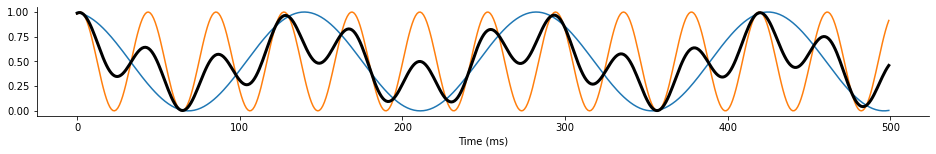

In [3]:
plt.figure(figsize=(16,2))
plt.plot(sines[0,:,:,0].numpy())
plt.plot(y_data[0].cpu().numpy(), 'black', lw=3)
plt.xlabel('Time (ms)')

sns.despine()

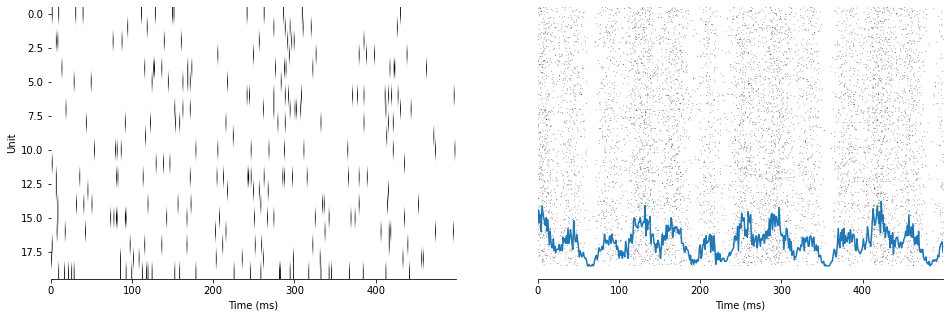

In [4]:
data_id = 0
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.imshow(x_data[data_id].cpu().t(), cmap=plt.cm.gray_r, aspect="auto")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()

ax = plt.subplot(122)
plt.imshow(x_data.permute(2,0,1).reshape(-1, cantata.cfg.n_steps).cpu(), cmap=plt.cm.gray_r, aspect="auto")
m = torch.mean(x_data, dim=(0,2)).cpu()
plt.plot(cantata.cfg.batch_size * cantata.cfg.n_inputs * (1 - m/max(m) / 4))
plt.xlabel("Time (ms)")
ax.yaxis.set_visible(False)
sns.despine(left=True)

Then, check that the model behaves reasonably before training:

In [12]:
model = cantata.Module(record_hidden = True)
output = model(x_data)

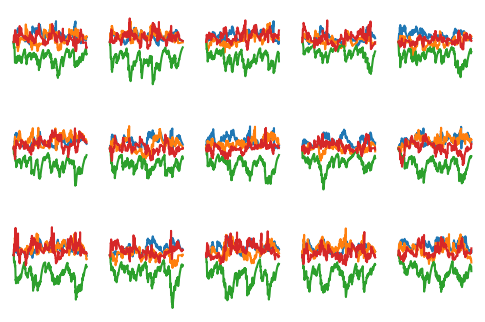

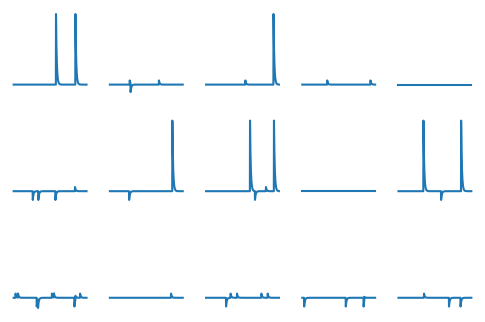

In [13]:
ovis.plot_voltage_traces(model.mem_rec, fig=plt.figure(dpi=100))
ovis.plot_voltage_traces(output, fig=plt.figure(dpi=100));

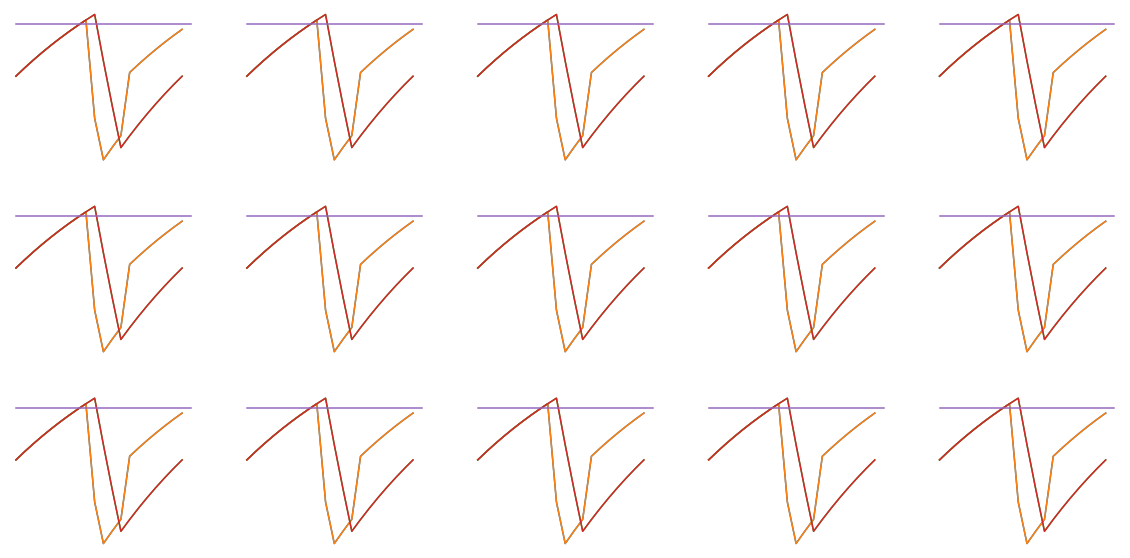

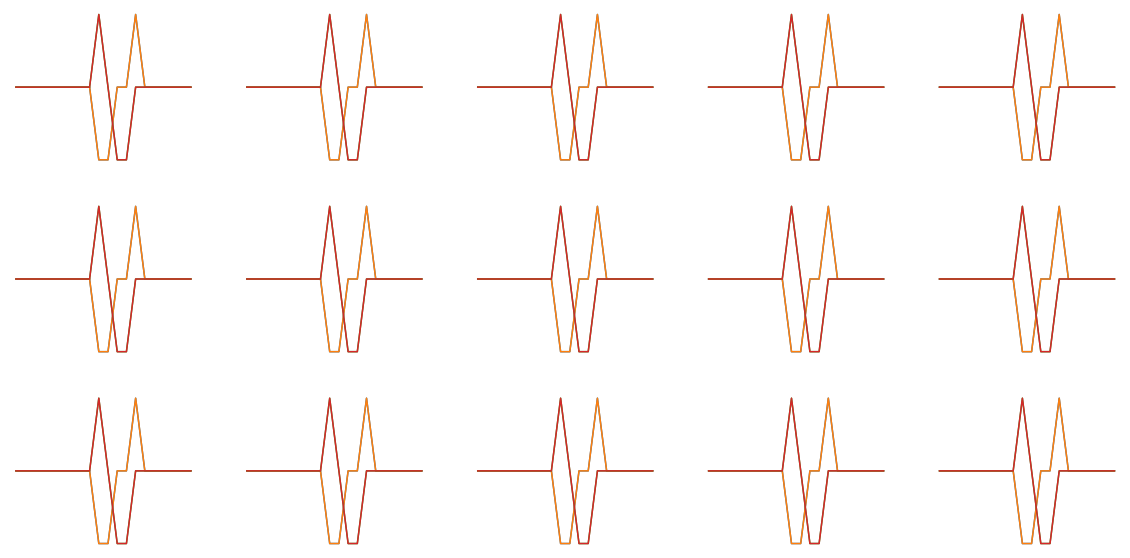

In [2]:
# Delay testing
cantata.cfg.batch_size = 15
cantata.cfg.model.populations.Exc1.targets.Exc1.density = 1
cantata.cfg.model.populations.Exc1.targets.Exc1.delay = 5e-3
cantata.cfg.model.populations.Exc1.targets.Inh1.density = 0
cantata.cfg.model.populations.Inh1.targets.Exc1.density = 0
cantata.cfg.model.populations.Inh1.targets.Inh1.density = 0
cantata.cfg.model.populations.Inh1.targets.Inh1.delay = 3e-3
model = cantata.Module(record_hidden = True)
with torch.no_grad():
    model.w_in[:] = .008
    model.w[:] = .5
model(torch.ones(cantata.cfg.batch_size, cantata.cfg.n_steps, cantata.cfg.n_inputs, **cantata.cfg.tspec))
ax = ovis.plot_voltage_traces(model.mem_rec[:,:20,:], fig=plt.figure(figsize=(20,10)))
for a in ax:
    a.plot([0,20],[1,1])
    
ax = ovis.plot_voltage_traces(model.syn_rec[:,:20,:], fig=plt.figure(figsize=(20,10)))
    
# print(model.spk_rec[0, :20])

In [3]:
spk_rec = torch.transpose(model.spk_rec,0,1)
p_rec = torch.transpose(model.p_rec,0,1)
offset = 12
static_weights = model.dmap * \
            torch.einsum('e,eo->eo', model.w_signs, torch.abs(model.w))

tmp = spk_rec[offset - model.delays] * (1+p_rec[offset - model.delays])
syn_p = torch.einsum('dbe,deo->bo', tmp, static_weights)
print(static_weights)
print(tmp[:,0,:])
print(syn_p[0])
print(model.mem_rec[0,:20])
# model.spk_rec[0,:20]

tensor([[[ 0.0000,  0.0000,  0.5000,  0.5000],
         [ 0.0000,  0.0000,  0.5000,  0.5000],
         [-0.5000, -0.5000, -0.0000, -0.0000],
         [-0.5000, -0.5000, -0.0000, -0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [-0.0000, -0.0000, -0.5000, -0.5000],
         [-0.0000, -0.0000, -0.5000, -0.5000]],

        [[ 0.5000,  0.5000,  0.0000,  0.0000],
         [ 0.5000,  0.5000,  0.0000,  0.0000],
         [-0.0000, -0.0000, -0.0000, -0.0000],
         [-0.0000, -0.0000, -0.0000, -0.0000]]], device='cuda:0',
       grad_fn=<MulBackward0>)
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 1., 1., 1.]], device='cuda:0', grad_fn=<SliceBackward>)
tensor([1., 1., 0., 0.], device='cuda:0', grad_fn=<SelectBackward>)
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.6000e-01,  1.6000e-01,  1.6000e-01,  1.6000e-01],
        [ 3.1220e-01,  3.1220e-01,  3.1220e-01,  3.1220e-01],
       

In [7]:
loss_fn = torch.nn.MSELoss()
print("Mean squared error: %.3f" % loss_fn(output, y_data))

Mean squared error: 0.304


I have no idea whether this will train! Let's try.

Forward, backward, overhead: 0.245 s; 0.199 s; 0.010 s
Forward, backward, overhead: 0.233 s; 0.209 s; 0.006 s
Forward, backward, overhead: 0.241 s; 0.215 s; 0.007 s
Forward, backward, overhead: 0.237 s; 0.214 s; 0.007 s
Forward, backward, overhead: 0.247 s; 0.214 s; 0.007 s


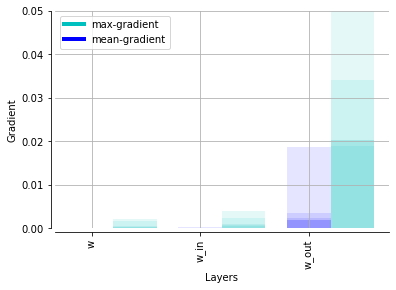

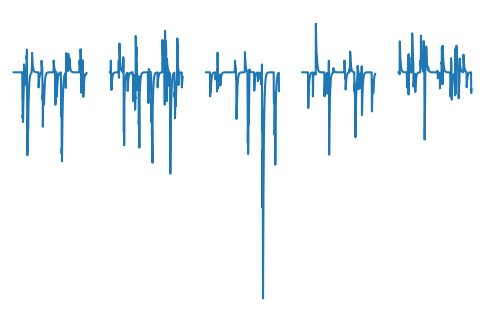

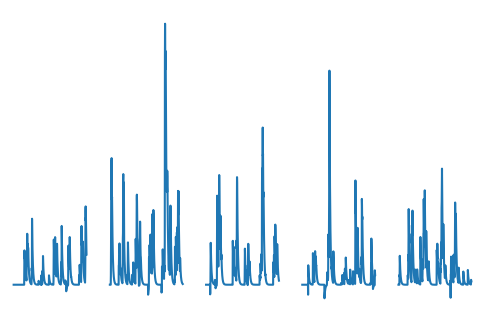

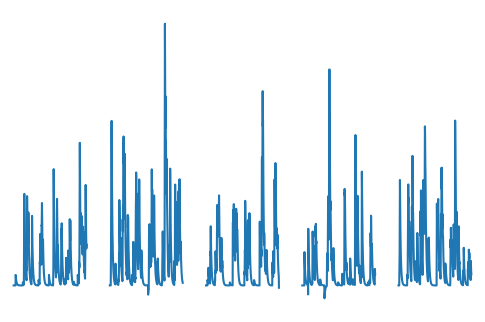

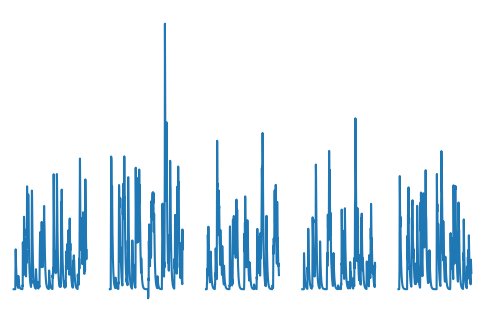

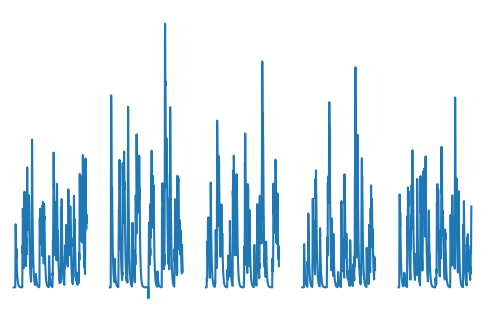

In [8]:
model = cantata.Module()
with torch.no_grad():
    untrained = model(x_data)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, betas=(0.9,0.999)) # The optimizer we are going to use

epochs, reporting_interval = 50, 10
t_forward = t_backward = overhead = 0
tic = time.perf_counter()

ax = plt.figure().subplots()
plot_grad = pvis.get_grad_plotter(top=.05)

# The optimization loop
loss_hist = []
for e in range(epochs):
    # run the network and get output
    overhead += time.perf_counter() - tic
    tic = time.perf_counter()
    
    output = model(x_data)
    
    toc = time.perf_counter()
    t_forward += toc-tic
    
    # compute the loss
    loss_val = loss_fn(output, y_data)

    # update the weights
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    
    tic = time.perf_counter()
    t_backward += tic-toc
    
    # store loss value
    loss_hist.append(loss_val.item())
    
    if e%reporting_interval == 0:
        plot_grad(model.named_parameters(), ax)
        ovis.plot_voltage_traces(output, dim=(1,5), fig=plt.figure(dpi=100))
        if e > 0:
            t_forward /= reporting_interval
            t_backward /= reporting_interval
            overhead /= reporting_interval
        print("Forward, backward, overhead: %0.3f s; %0.3f s; %0.3f s" % (t_forward, t_backward, overhead))
        t_forward = t_backward = overhead = 0

0.1431715488433838


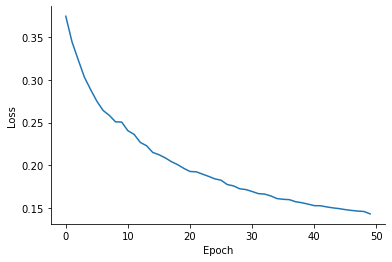

In [9]:
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()
print(loss_hist[-1])

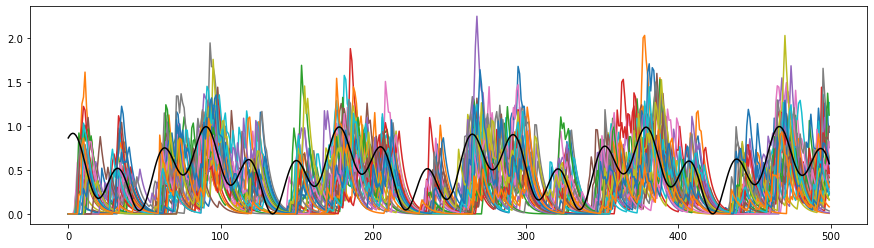

In [10]:
plt.figure(figsize=(15,4))
plt.plot(output[:,:,0].detach().cpu().numpy().T)
plt.plot(y_data[0,:,0].cpu().numpy(), color='black');

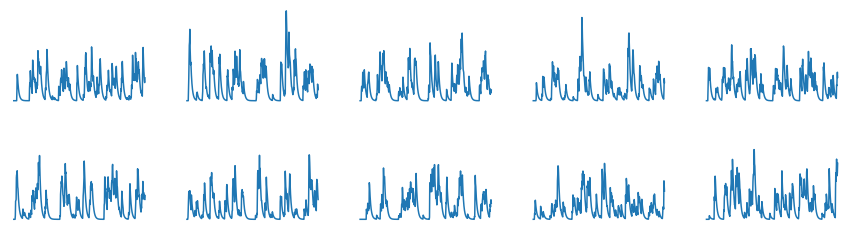

In [11]:
fig=plt.figure(figsize=(15,4))
ovis.plot_voltage_traces(output,dim=(2,5),fig=fig);

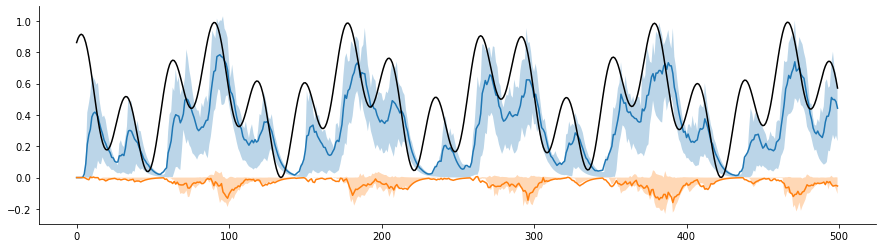

In [12]:
plt.figure(figsize=(15,4))
for out in (output, untrained):
    plt.plot(out[:,:,0].detach().mean(dim=0).cpu().numpy().T)
    lo,hi = [torch.quantile(out[:,:,0].detach(), q, dim=0).cpu().numpy() for q in (.25,.75)]
    plt.fill_between(np.arange(len(lo)), lo, hi, alpha=.3)
plt.plot(y_data[0,:,0].cpu().numpy(), color='black')
sns.despine()

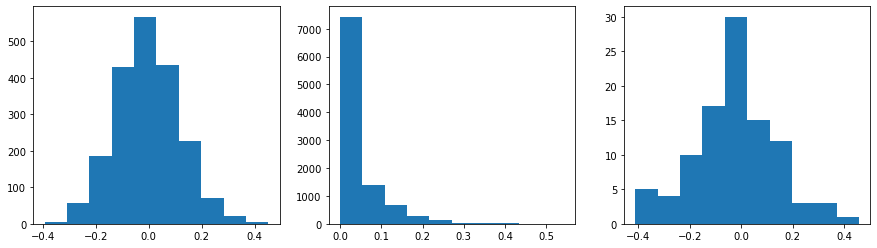

In [13]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.hist(model.w_in.detach().cpu().numpy().flat)
plt.subplot(132)
plt.hist(model.w.detach().abs().cpu().numpy().flat)
plt.subplot(133)
plt.hist(model.w_out.detach().cpu().numpy().flat);